In [1]:
import math
import numpy as np
from six.moves import xrange
import tensorflow as tf

import tensorflow_constrained_optimization as tfco

In [2]:
np.random.seed(10)

def predictions():
    return tf.tensordot(yro, mean_r, axes=(1, 0)) - threshold

num_examples = 1000
num_mislabeled_examples = 200
dimension = 10

recall_lower_bound = 0.9

# Create random "ground truth" parameters for a linear model.
input_weights = np.random.normal(size=dimension) / math.sqrt(dimension)
ground_truth_threshold = 0.9

mean_r = tf.Variable(tf.zeros(dimension), dtype=tf.float32, name="weights")
threshold = tf.Variable(0.0, dtype=tf.float32, name="threshold")

input_data = np.random.normal(size=(num_examples, dimension)).astype(
    np.float32) / math.sqrt(dimension)

labels = (np.matmul(input_data, input_weights) >
          ground_truth_threshold).astype(np.float32)
# Add noise by randomly flipping num_mislabeled_examples labels.
mislabeled_indices = np.random.choice(
    num_examples, num_mislabeled_examples, replace=False)
labels[mislabeled_indices] = 1 - labels[mislabeled_indices]

constant_labels = tf.constant(labels, dtype=tf.float32)
constant_input = tf.constant(input_data, dtype=tf.float32)
yro = constant_input

context = tfco.rate_context(predictions, labels=lambda: constant_labels)
problem = tfco.RateMinimizationProblem(
    tfco.error_rate(context), [tfco.recall(context) >= recall_lower_bound])

In [3]:
class ExampleProblem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, labels, predictions, recall_lower_bound):
        self._labels = labels
        self._predictions = predictions
        self._recall_lower_bound = recall_lower_bound
        # The number of positively-labeled examples.
        self._positive_count = tf.reduce_sum(self._labels)

    @property
    def num_constraints(self):
        return 1
    
    # we use hinge loss because we need to capture those that are not classified correctly and minimize that loss
    def objective(self):
        predictions = self._predictions
        if callable(predictions):
            predictions = predictions()
        return tf.compat.v1.losses.hinge_loss(labels=self._labels,
          logits=predictions)
    
    def constraints(self):
        # In eager mode, the predictions must be a nullary function returning a
        # Tensor. In graph mode, they could be either such a function, or a Tensor
        # itself.
        predictions = self._predictions
        if callable(predictions):
            predictions = predictions()
        # Recall that the labels are binary (0 or 1).
        true_positives = self._labels * tf.cast(predictions > 0, dtype=tf.float32)
        true_positive_count = tf.reduce_sum(true_positives)
        recall = true_positive_count / self._positive_count
        # The constraint is (recall >= self._recall_lower_bound), which we convert
        # to (self._recall_lower_bound - recall <= 0) because
        # ConstrainedMinimizationProblems must always provide their constraints in
        # the form (tensor <= 0).
        #
        # The result of this function should be a tensor, with each element being
        # a quantity that is constrained to be non-positive. We only have one
        # constraint, so we return a one-element tensor.
        return self._recall_lower_bound - recall
    
    def proxy_constraints(self):
        # In eager mode, the predictions must be a nullary function returning a
        # Tensor. In graph mode, they could be either such a function, or a Tensor
        # itself.
        predictions = self._predictions
        if callable(predictions):
            predictions = predictions()
        # Use 1 - hinge since we're SUBTRACTING recall in the constraint function,
        # and we want the proxy constraint function to be convex. Recall that the
        # labels are binary (0 or 1).
        true_positives = self._labels * tf.minimum(1.0, predictions)
        true_positive_count = tf.reduce_sum(true_positives)
        recall = true_positive_count / self._positive_count
        # Please see the corresponding comment in the constraints property.
        return self._recall_lower_bound - recall

problem = ExampleProblem(
    labels=constant_labels,
    predictions=predictions,
    recall_lower_bound=recall_lower_bound,
)

In [4]:
def average_hinge_loss(labels, predictions):
    # Recall that the labels are binary (0 or 1).
    signed_labels = (labels * 2) - 1
    return np.mean(np.maximum(0.0, 1.0 - signed_labels * predictions))

def recall(labels, predictions):
    # Recall that the labels are binary (0 or 1).
    positive_count = np.sum(labels)
    true_positives = labels * (predictions > 0)
    true_positive_count = np.sum(true_positives)
    return true_positive_count / positive_count

In [5]:
if tf.executing_eagerly():
    # In eager mode, we use a V2 optimizer (a tf.keras.optimizers.Optimizer). A V1
    # optimizer, however, would work equally well.
    optimizer = tfco.ProxyLagrangianOptimizerV2(
      optimizer=tf.keras.optimizers.Adagrad(learning_rate=1.0),
      num_constraints=problem.num_constraints)
    # In addition to the model parameters (weights and threshold), we also need to
    # optimize over any trainable variables associated with the problem (e.g.
    # implicit slack variables and weight denominators), and those associated with
    # the optimizer (the analogues of the Lagrange multipliers used by the
    # proxy-Lagrangian formulation).
    var_list = ([mean_r, threshold] + problem.trainable_variables +
              optimizer.trainable_variables())

    for ii in xrange(1000):
        optimizer.minimize(problem, var_list=var_list)

    trained_weights = mean_r.numpy()
    trained_threshold = threshold.numpy()

else:  # We're in graph mode.
    # In graph mode, we use a V1 optimizer (a tf.compat.v1.train.Optimizer). A V2
    # optimizer, however, would work equally well.
    optimizer = tfco.ProxyLagrangianOptimizerV1(
      optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=1.0))
    train_op = optimizer.minimize(problem)

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for ii in xrange(1000):
            session.run(train_op)

        trained_weights, trained_threshold = session.run((weights, threshold))

trained_predictions = np.matmul(input_data, trained_weights) - trained_threshold
print("Constrained average hinge loss = %f" % average_hinge_loss(
    labels, trained_predictions))
print("Constrained recall = %f" % recall(labels, trained_predictions))

Constrained average hinge loss = 1.185147
Constrained recall = 0.845000


<AxesSubplot:>

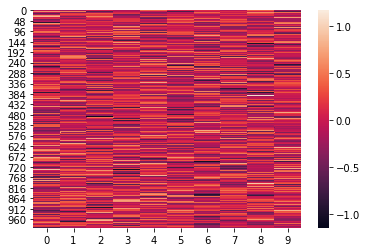

In [6]:
import seaborn
seaborn.heatmap(yro.numpy())